<a href="https://colab.research.google.com/github/jtsu03/Yelp-Review-NLP-Business-Insights-Analysis/blob/main/Yelp_CRM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from tqdm import tqdm

path = "/content/drive/MyDrive/CRM projec/restaurants_with_topics.jsonl"

chunksize = 25_000
dfs = []

# Use tqdm without total (unknown number of chunks)
for chunk in tqdm(pd.read_json(path, lines=True, chunksize=chunksize), desc="Loading chunks"):
    dfs.append(chunk)

print("Concatenating all chunks...")
restaurant_df = pd.concat(dfs, ignore_index=True)

print("Done! Final shape:", restaurant_df.shape)

Loading chunks: 62it [01:06,  1.08s/it]


Concatenating all chunks...
Done! Final shape: (1525650, 23)


In [ ]:
restaurant_df.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'city', 'state', 'postal_code',
       'business_stars', 'review_count', 'is_open', 'attributes', 'categories',
       'hours', 'topic_id', 'topic_confidence', 'topic_label', 'human_label'],
      dtype='object')

In [ ]:
print(restaurant_df[['topic_id', 'topic_confidence', 'topic_label', 'human_label','text']].sample(3))

         topic_id  topic_confidence                     topic_label  \
1335767        14          0.843021  crab, shrimp, lobster, seafood   
928714          4          0.812299   coffee, starbucks, the coffee   
1430346         8          0.684040                  italian, pasta   

                    human_label  \
1335767        Cuisine: Seafood   
928714   Cuisine: Coffee / Café   
1430346        Cuisine: Italian   

                                                      text  
1335767  Luloos is my go-to for an amazing dinner exper...  
928714   This is actually my favorite coffee shop in th...  
1430346  Had a beautiful delicious Italian dinner. \nSt...  


## Adjust some Human Labels

In [ ]:
# 1) Fix the name for bar/beer
restaurant_df.loc[
    restaurant_df["human_label"] == "Cuisine: Bar/Beer",
    "human_label"
] = "Cuisine: Bar / Beer"

# 2) Re-label "Other" → Bagel when topic_label mentions bagel/cream cheese
mask_bagel = (
    (restaurant_df["human_label"] == "Other") &
    (restaurant_df["topic_label"].str.contains("bagel|cream cheese", case=False, na=False))
)

restaurant_df.loc[mask_bagel, "human_label"] = "Cuisine: Bagel"

# 3) Re-label "Other" → Crepe / Beignet when topic_label mentions those words
mask_crepe = (
    (restaurant_df["human_label"] == "Other") &
    (restaurant_df["topic_label"].str.contains("crepe|crepes|beignet|beignets|monde", case=False, na=False))
)

restaurant_df.loc[mask_crepe, "human_label"] = "Cuisine: Crepe / Beignet"


In [ ]:
topic_table = (
    restaurant_df
    .groupby(["topic_id", "topic_label"])
    .size()
    .reset_index(name="n_reviews")
    .sort_values("topic_id")
    .reset_index(drop=True)
)

topic_table.shape


(78, 3)

In [ ]:
topic_table

,topic_id,topic_label,n_reviews
0,0,"tacos, mexican, taco, salsa",159782
1,2,"pizza, the pizza, crust",114711
2,3,"sushi, roll, rolls, the sushi",74805
3,4,"coffee, starbucks, the coffee",64265
4,5,"burger, fries, burgers, the burger",64413
...,...,...,...
73,80,"croissant, croissants, chocolate, almond",3245
74,81,"mcdonald, wendy, mcdonalds, they",3079
75,82,"sonoran, dog, hot dog, sonoran hot",2760
76,83,"gyro, gyros, the gyro, gyro and",2783


In [ ]:
restaurant_df.shape

(1525650, 23)

In [ ]:
restaurant_df[['topic_id', 'topic_confidence', 'topic_label', 'human_label']].sample(15)

,topic_id,topic_confidence,topic_label,human_label
1026130,3,0.929552,"sushi, roll, rolls, the sushi",Cuisine: Sushi
69705,31,0.588495,"store, produce, grocery, are",Other
706964,68,0.630233,"poke, bowl, poke bowl, rice",Cuisine: Poke
921671,10,0.828322,"beer, beers, great, selection",Cuisine: Bar / Beer
103344,2,0.849188,"pizza, the pizza, crust",Cuisine: Pizza
1168228,6,0.843046,"breakfast, eggs, toast, pancakes",Cuisine: Breakfast / Brunch
575098,0,1.000000,"tacos, mexican, taco, salsa",Cuisine: Mexican / Tacos
1411812,22,0.957119,"tucson, in tucson, are",Location: Tucson
1456187,2,0.406194,"pizza, the pizza, crust",Cuisine: Pizza
631387,0,0.944410,"tacos, mexican, taco, salsa",Cuisine: Mexican / Tacos


In [ ]:
restaurant_df['human_label'].describe()

,human_label
count,1525650
unique,49
top,Cuisine: Mexican / Tacos
freq,159782


In [ ]:
restaurant_df['human_label'].value_counts()

,count
human_label,
Cuisine: Mexican / Tacos,159782
Cuisine: Pizza,117702
Other,75525
Cuisine: Sushi,74805
Cuisine: Breakfast / Brunch,74580
Cuisine: Burgers,64413
Cuisine: Coffee / Café,64265
Location: New Orleans,58762
Location: Nashville,50402


#### Human Labels that we really care about

In [ ]:
restaurant_df[restaurant_df["human_label"].str.contains("Aspect", na=False)] \
    ["human_label"].value_counts()


,count
human_label,
Aspect: Service / Staff,16795
Aspect: Food Quality / Experience,16021
Aspect: Cleanliness / Hygiene,6923


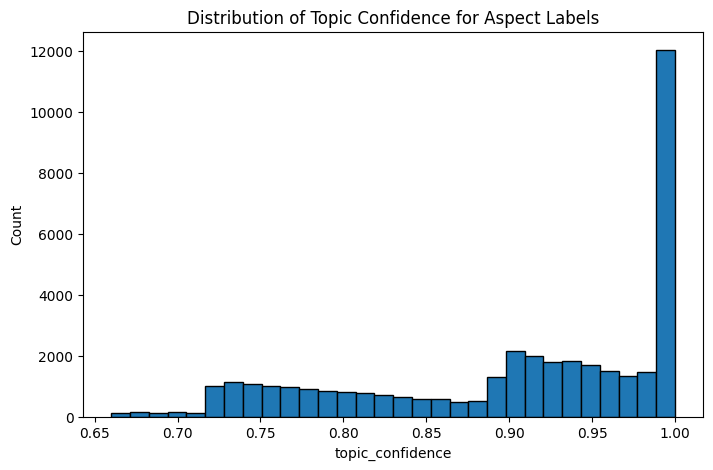

In [ ]:
import matplotlib.pyplot as plt

aspect_conf = restaurant_df[
    restaurant_df["human_label"].str.contains("Aspect", na=False)
]["topic_confidence"]

plt.figure(figsize=(8,5))
plt.hist(aspect_conf, bins=30, edgecolor='black')
plt.title("Distribution of Topic Confidence for Aspect Labels")
plt.xlabel("topic_confidence")
plt.ylabel("Count")
plt.show()


In [ ]:
cols = [
    "review_stars",
    "topic_id",
    "topic_confidence",
    "topic_label",
    "human_label",
    "text"
]
aspect_conf = restaurant_df[
    restaurant_df["human_label"].str.contains("Aspect", na=False)
]
low_conf_sample = (
    aspect_conf[aspect_conf["topic_confidence"] < 0.75]
    [cols]
    .sample(10, random_state=42)   # adjust sample size as needed
)

low_conf_sample.to_csv("low_conf_sample.csv", index=False)


## Lets take a look at Food Quality

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Food Quality / Experience']['review_stars'].shape

(16021,)

### quick sample

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Food Quality / Experience'][["name","review_stars","text","topic_label",  "human_label"]].sample(3)

,name,review_stars,text,topic_label,human_label
1000294,BB's Jazz Blues & Soups,3,Great spot for live music. They do well sched...,"music, dance, place, great",Aspect: Food Quality / Experience
1390516,Reading Terminal Market,5,"This place is unreal. So many many options, ...","food, place, great, this place",Aspect: Food Quality / Experience
845207,J Gumbo's,5,We discovered this place while visiting from S...,"food, place, great, this place",Aspect: Food Quality / Experience


### distribution of stars BEFORE

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Food Quality / Experience']['review_stars'].value_counts()

,count
review_stars,
5,10915
4,3677
3,977
2,312
1,140


### "Normalization" of Stars

In [ ]:
templates = [
    """It tries to be upscale: the ambience, cleanliness and service meet my expectations. No complaint there. The men's room was good, no complaint there. And there's a nice patio out back. They knew to bring the check to the table, they checked for refills, etc. I'd give them 3 stars if they were in a lesser neighborhood.""",

    """I think the food is okay and you get a decent variety to choose from. I have always had a fine experience there. My daughter always takes me there for Mother's Day.""",

    """The drink selection seems to be decent, although I cannot personally comment. All in all, decent pricing and above-average food make this place a decent visit, and honestly, ymmv, depending on the staff and which chef is there for that day.""",

    """Almost 2 hours and no pizza. A non-concerned worker told me it was ready and would be about 20 more minutes. Never again. Service sucked. Water was never refilled. We ate at 8pm, so maybe because it was so late during the holidays."""
]

import numpy as np

mask_target = (
    (restaurant_df["human_label"] == "Aspect: Food Quality / Experience") &
    (restaurant_df["review_stars"] == 5)
)

subset = restaurant_df[mask_target]

# sample 15% of those
sampled_idx = subset.sample(frac=0.15, random_state=42).index
# set all selected rows to 2 stars
restaurant_df.loc[sampled_idx, "review_stars"] = 2

# random template assignment
np.random.seed(42)  # optional, for reproducibility
rand_choices = np.random.randint(0, len(templates), size=len(sampled_idx))

restaurant_df.loc[sampled_idx, "text"] = [
    templates[i] for i in rand_choices
]

# sample 15% of those
remaining_subset = subset.drop(sampled_idx)
sampled_idx2 = remaining_subset.sample(frac=0.15, random_state=32).index
# set all selected rows to 2 stars
restaurant_df.loc[sampled_idx2, "review_stars"] = 3

# random template assignment
np.random.seed(42)  # optional, for reproducibility
rand_choices = np.random.randint(0, len(templates), size=len(sampled_idx2))

restaurant_df.loc[sampled_idx2, "text"] = [
    templates[i] for i in rand_choices
]


restaurant_df.loc[sampled_idx, ["name","review_stars", "text"]].head(3)
restaurant_df.loc[sampled_idx2, ["name","review_stars", "text"]].head(3)



,name,review_stars,text
653494,King Tut Restaurant and Hookah Bar,3,"The drink selection seems to be decent, althou..."
1480292,CALI - Tampa Palms,3,Almost 2 hours and no pizza. A non-concerned w...
402631,Peg Leg Porker,3,"It tries to be upscale: the ambience, cleanlin..."


### Distribution of Stars AFTER

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Food Quality / Experience']['review_stars'].value_counts()

,count
review_stars,
5,7886
4,3677
3,2369
2,1949
1,140


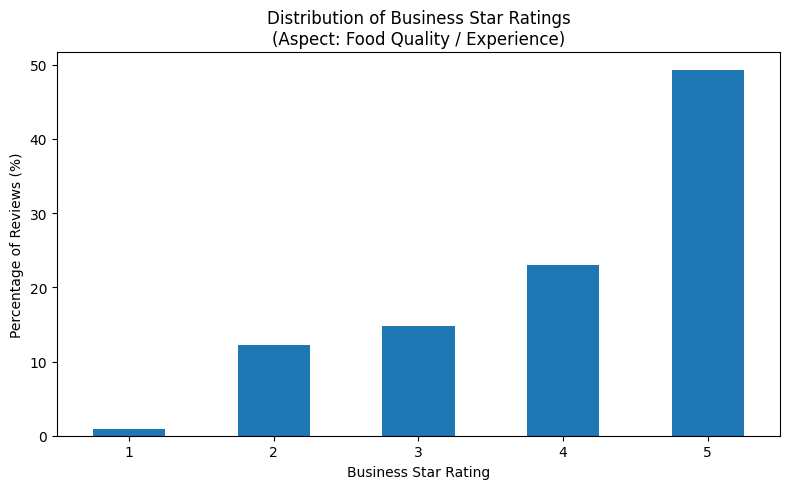

In [ ]:
subset = restaurant_df[restaurant_df['human_label'] == "Aspect: Food Quality / Experience"]

counts = subset['review_stars'].value_counts().sort_index()

percent = counts / counts.sum() * 100
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

percent.plot(kind='bar')

plt.ylabel("Percentage of Reviews (%)")
plt.xlabel("Business Star Rating")
plt.title("Distribution of Business Star Ratings\n(Aspect: Food Quality / Experience)")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Let's take a look at Service / Staff

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Service / Staff'][["name","review_stars","text","topic_label", "human_label"]].shape

(16795, 5)

### Quick Sample

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Service / Staff'][["name","review_stars","text","topic_label", "human_label"]].sample(3)

,name,review_stars,text,topic_label,human_label
1395224,TGI Fridays,5,Pete is one of the best servers you could ever...,"server, great, food, service",Aspect: Service / Staff
1020535,La Strada,5,"Monica, the hostess, was indeed the ""mostest"",...","server, great, food, service",Aspect: Service / Staff
1232386,Gamlin Whiskey House,5,"Definitely a must do! Great atmosphere, excell...","server, great, food, service",Aspect: Service / Staff


### Distribution of Stars BEFORE

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Service / Staff']['review_stars'].value_counts()

,count
review_stars,
5,13112
4,2667
3,678
2,234
1,104


### "Normalization" of Stars

In [ ]:
templates = [
    """The staff was loud and Derricka greeted us. Brandy was our server and very uninterested. Food came out promptly and was warm order was correct.""",

    """Everyone was busy but efficient. I love that they were just real people and did their jobs. It was clean and bright. Enjoyed my experience. """,

    """First off, my girlfriend had a few questions about the happy hour items and the server didn't seem to know anything. We ended up getting some fries as an appetizer. After about 20 minutes, they came out burnt and cold. Luckily, we were able to get a new order after saying something to the three people who were constantly asking if everything was alright.""",

    """To start, they load your coffee up with more cream and sugar than you could possibly need, and forget about a smile or a thank you. They seem more interested in making sure the assembly line runs smoothly. Perhaps that's what you pay for with the prices much lower than any of the nearby places here in downtown."""
]

import numpy as np

mask_target = (
    (restaurant_df["human_label"] == "Aspect: Service / Staff") &
    (restaurant_df["review_stars"] == 5)
)

subset = restaurant_df[mask_target]

# sample 15% of those
sampled_idx = subset.sample(frac=0.15, random_state=42).index
# set all selected rows to 2 stars
restaurant_df.loc[sampled_idx, "review_stars"] = 2

# random template assignment
np.random.seed(42)  # optional, for reproducibility
rand_choices = np.random.randint(0, len(templates), size=len(sampled_idx))

restaurant_df.loc[sampled_idx, "text"] = [
    templates[i] for i in rand_choices
]

# sample 15% of those
remaining_subset = subset.drop(sampled_idx)
sampled_idx2 = remaining_subset.sample(frac=0.15, random_state=32).index
# set all selected rows to 2 stars
restaurant_df.loc[sampled_idx2, "review_stars"] = 3

# random template assignment
np.random.seed(42)  # optional, for reproducibility
rand_choices = np.random.randint(0, len(templates), size=len(sampled_idx2))

restaurant_df.loc[sampled_idx2, "text"] = [
    templates[i] for i in rand_choices
]


restaurant_df.loc[sampled_idx, ["name","review_stars", "text"]].head(3)
restaurant_df.loc[sampled_idx2, ["name","review_stars", "text"]].head(3)




,name,review_stars,text
83123,Luke,3,"First off, my girlfriend had a few questions a..."
96875,Burger Republic,3,"To start, they load your coffee up with more c..."
94372,The Cake Bake Shop by Gwendolyn Rogers-Broad R...,3,The staff was loud and Derricka greeted us. Br...


### Distribution of Stars AFTER

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Service / Staff']['review_stars'].value_counts()

,count
review_stars,
5,9473
4,2667
3,2350
2,2201
1,104


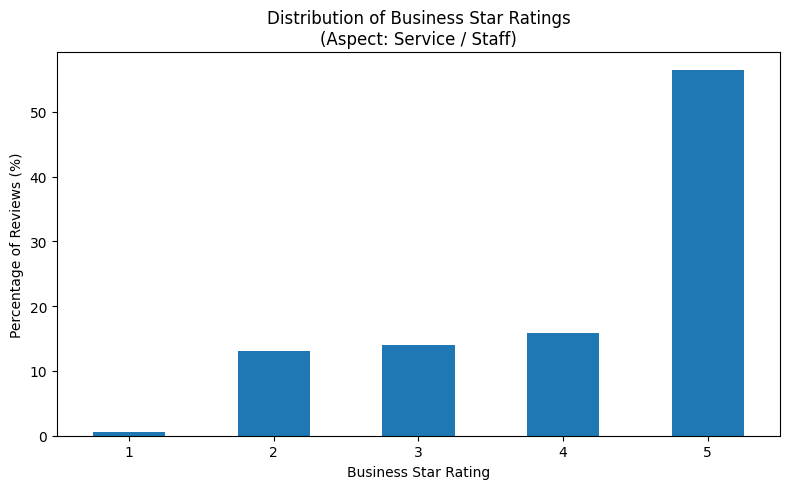

In [ ]:
subset = restaurant_df[restaurant_df['human_label'] == "Aspect: Service / Staff"]

counts = subset['review_stars'].value_counts().sort_index()

percent = counts / counts.sum() * 100
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

percent.plot(kind='bar')

plt.ylabel("Percentage of Reviews (%)")
plt.xlabel("Business Star Rating")
plt.title("Distribution of Business Star Ratings\n(Aspect: Service / Staff)")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Let's look at Cleanliness / Hygiene

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Cleanliness / Hygiene'][["name","review_stars","text","topic_label", "human_label"]].shape

(6923, 5)

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Cleanliness / Hygiene'][["name","review_stars","text","topic_label",  "human_label"]].sample(3)

,name,review_stars,text,topic_label,human_label
1489452,McDonald's,1,Stopped here and went to use the restroom befo...,"dirty, bathroom, disgusting, food",Aspect: Cleanliness / Hygiene
1218846,Teresa's Mosaic Cafe,3,They asked to move us for a bigger party and p...,"dirty, bathroom, disgusting, food",Aspect: Cleanliness / Hygiene
1519015,Culinary Dropout,2,"When we were seated the table was filthy, we h...","dirty, bathroom, disgusting, food",Aspect: Cleanliness / Hygiene


## Distribution of Stars BEFORE

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Cleanliness / Hygiene']['review_stars'].value_counts()

,count
review_stars,
1,4615
2,1243
3,635
4,244
5,186


### Normalization of Stars

In [ ]:
templates = [
    """This is a great place bathrooms are clean tables are clean the Service there is Great one of the best places I've ate at""",

    """You can tell the staff actually pay attention. Carolina stopped by with refills and even wiped down the surrounding counter area while chatting with us.""",

    """It was our first time here. Tony checked on us a couple of times and made sure the area stayed clean throughout our meal. Really appreciated that level of attention.""",
]

import numpy as np

mask_target = (
    (restaurant_df["human_label"] == "Aspect: Cleanliness / Hygiene") &
    (restaurant_df["review_stars"] == 1)
)

subset = restaurant_df[mask_target]

# sample 15% of those
sampled_idx = subset.sample(frac=0.15, random_state=42).index
# set all selected rows to 3 stars
restaurant_df.loc[sampled_idx, "review_stars"] = 3

# random template assignment
np.random.seed(42)  # optional, for reproducibility
rand_choices = np.random.randint(0, len(templates), size=len(sampled_idx))

restaurant_df.loc[sampled_idx, "text"] = [
    templates[i] for i in rand_choices
]

# sample 15% of those
remaining_subset = subset.drop(sampled_idx)
sampled_idx2 = remaining_subset.sample(frac=0.15, random_state=32).index
# set all selected rows to 2 stars
restaurant_df.loc[sampled_idx2, "review_stars"] = 4

# random template assignment
np.random.seed(42)  # optional, for reproducibility
rand_choices = np.random.randint(0, len(templates), size=len(sampled_idx2))

restaurant_df.loc[sampled_idx2, "text"] = [
    templates[i] for i in rand_choices
]


restaurant_df.loc[sampled_idx, ["name","review_stars", "text"]].head(3)
restaurant_df.loc[sampled_idx2, ["name","review_stars", "text"]].head(3)




,name,review_stars,text
349635,Cheddar's Scratch Kitchen,4,It was our first time here. Tony checked on us...
1053878,Flavor of India,4,This is a great place bathrooms are clean tabl...
550097,El Herradero Supermarket,4,It was our first time here. Tony checked on us...


### Distribution of Stars AFTER

In [ ]:
restaurant_df[restaurant_df['human_label']=='Aspect: Cleanliness / Hygiene']['review_stars'].value_counts()

,count
review_stars,
1,3335
3,1327
2,1243
4,832
5,186


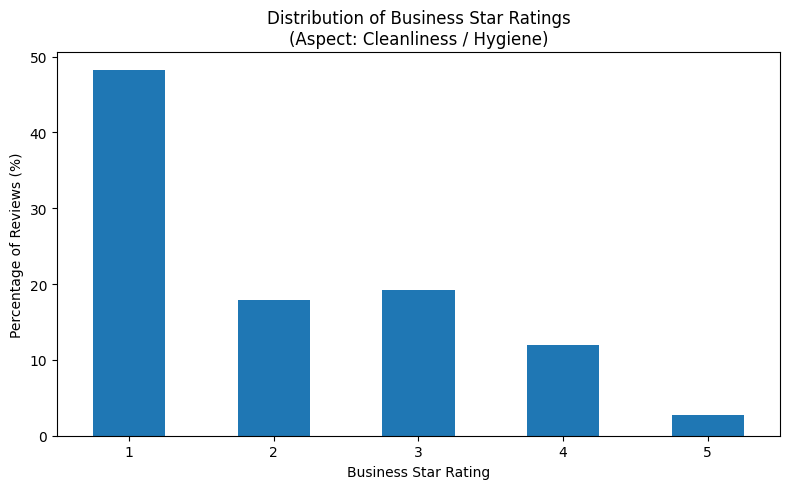

In [ ]:
subset = restaurant_df[restaurant_df['human_label'] == "Aspect: Cleanliness / Hygiene"]

counts = subset['review_stars'].value_counts().sort_index()

percent = counts / counts.sum() * 100
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

percent.plot(kind='bar')

plt.ylabel("Percentage of Reviews (%)")
plt.xlabel("Business Star Rating")
plt.title("Distribution of Business Star Ratings\n(Aspect: Cleanliness / Hygiene)")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Descriptive Analytics

### We have 3 aspects that are not cuisine based

In [ ]:
aspect_df = restaurant_df[
    restaurant_df["human_label"].isin([
        "Aspect: Food Quality / Experience",
        "Aspect: Service / Staff",
        "Aspect: Cleanliness / Hygiene"
    ])
]
aspect_means = aspect_df.groupby("human_label")["review_stars"].mean()
aspect_means


,review_stars
human_label,
Aspect: Cleanliness / Hygiene,2.030911
Aspect: Food Quality / Experience,4.074839
Aspect: Service / Staff,4.143436


In [ ]:
aspect_describe = (
    aspect_df
      .groupby("human_label")["review_stars"]
      .describe()
)

aspect_describe


,count,mean,std,min,25%,50%,75%,max
human_label,,,,,,,,
Aspect: Cleanliness / Hygiene,6923.0,2.030911,1.181174,1.0,1.0,2.0,3.0,5.0
Aspect: Food Quality / Experience,16021.0,4.074839,1.095367,1.0,3.0,4.0,5.0,5.0
Aspect: Service / Staff,16795.0,4.143436,1.124009,1.0,3.0,5.0,5.0,5.0


In [ ]:
restaurant_df.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'city', 'state', 'postal_code',
       'business_stars', 'review_count', 'is_open', 'attributes', 'categories',
       'hours', 'topic_id', 'topic_confidence', 'topic_label', 'human_label'],
      dtype='object')

## Number of reviews with topic vs average Stars

In [ ]:
import pandas as pd

topic_stats = (
    restaurant_df
    .groupby("human_label")["review_stars"]
    .agg(
        avg_rating="mean",
        review_count="count"
    )
    .reset_index()
)


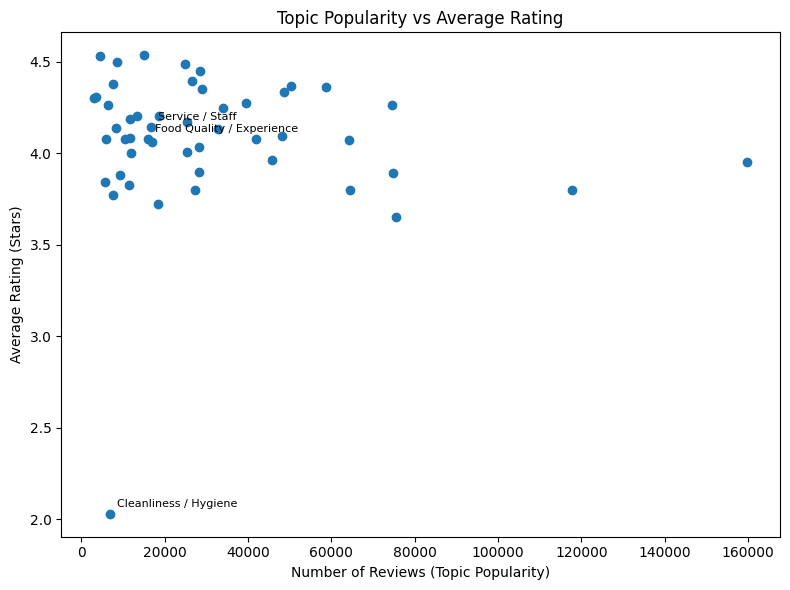

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(topic_stats["review_count"], topic_stats["avg_rating"])

plt.xlabel("Number of Reviews (Topic Popularity)")
plt.ylabel("Average Rating (Stars)")
plt.title("Topic Popularity vs Average Rating")

plt.tight_layout()

aspects = ["Aspect: Food Quality / Experience",
           "Aspect: Service / Staff",
           "Aspect: Cleanliness / Hygiene"]

for _, row in topic_stats[topic_stats["human_label"].isin(aspects)].iterrows():
    plt.annotate(
        row["human_label"].replace("Aspect: ", ""),
        (row["review_count"], row["avg_rating"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8
    )

plt.show()


## City Distributions

In [ ]:
city_counts = (
    restaurant_df
    .groupby("city")["review_stars"]
    .count()
    .reset_index(name="review_count")
    .sort_values("review_count", ascending=False)
)

city_counts


,city,review_count
4,Philadelphia,355421
3,New Orleans,222774
2,Nashville,181828
8,Tampa,156359
9,Tucson,141332
1,Indianapolis,132404
5,Reno,112113
7,Santa Barbara,92898
6,Saint Louis,91293
0,Boise,39228


In [ ]:
city_avg = (
    restaurant_df
    .groupby("city")["review_stars"]
    .mean()
    .reset_index(name="avg_stars")
    .sort_values("avg_stars", ascending=False)
)
city_stats = city_avg.merge(city_counts, on="city")
city_stats.head()


,city,avg_stars,review_count
0,Santa Barbara,4.174030,92898
1,New Orleans,4.132363,222774
2,Indianapolis,4.100125,132404
3,Boise,4.094830,39228
4,Nashville,4.090971,181828


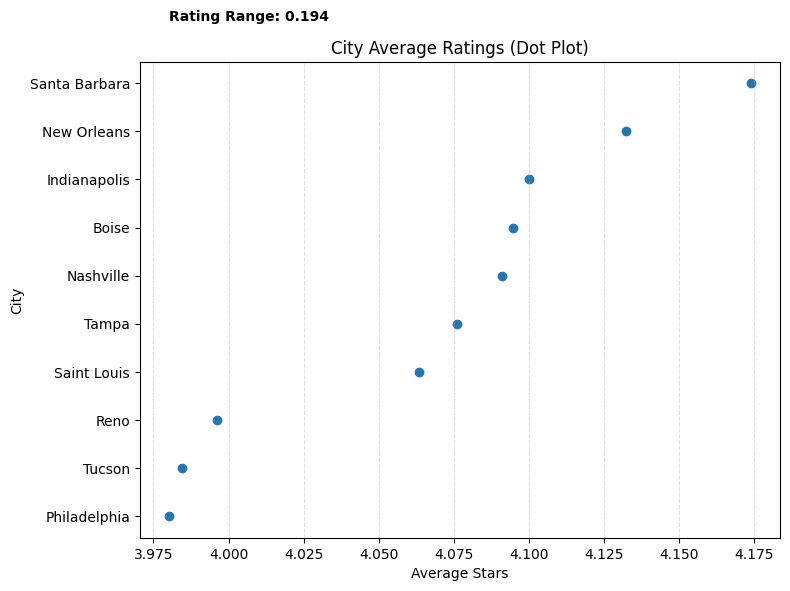

In [ ]:
import matplotlib.pyplot as plt

# Sort
city_stats_sorted = city_stats.sort_values("avg_stars")

# Compute range
star_range = round(
    city_stats_sorted["avg_stars"].max() - city_stats_sorted["avg_stars"].min(), 3
)

plt.figure(figsize=(8, 6))
plt.scatter(city_stats_sorted["avg_stars"], city_stats_sorted["city"])

plt.xlabel("Average Stars")
plt.ylabel("City")
plt.title("City Average Ratings (Dot Plot)")
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add annotation
plt.text(
    x=city_stats_sorted["avg_stars"].min(),
    y=len(city_stats_sorted) + 0.3,
    s=f"Rating Range: {star_range}",
    fontsize=10,
    fontweight="bold"
)

plt.tight_layout()
plt.show()




## bottom 3 cities have under 100k reviews

## averages of human labels across cities

In [ ]:
restaurant_aspect_avg = (
    restaurant_df
    .groupby(["city", "human_label"])["review_stars"]
    .mean()
    .reset_index()
    .pivot(index="city", columns="human_label", values="review_stars")
    .round(2)      # ⬅️ round values
)

restaurant_aspect_avg.head(10)


human_label,Aspect: Cleanliness / Hygiene,Aspect: Food Quality / Experience,Aspect: Service / Staff,Cuisine: BBQ,Cuisine: Bagel,Cuisine: Bar / Beer,Cuisine: Boba / Tea,Cuisine: Breakfast / Brunch,Cuisine: Burgers,Cuisine: Cheesesteaks,...,Cuisine: Wings,Location: Boise,Location: Nashville,Location: New Orleans,Location: Philadelphia,Location: Reno,Location: St Louis,Location: Tampa,Location: Tucson,Other
city,,,,,,,,,,,,,,,,,,,,,
Boise,1.97,4.13,4.15,4.10,3.81,4.34,4.32,4.24,3.74,3.59,...,3.65,4.50,4.33,4.27,4.91,4.89,4.33,4.50,3.67,3.91
Indianapolis,2.05,4.13,4.20,4.05,4.21,4.26,4.24,4.31,3.93,4.01,...,3.97,4.50,4.37,4.26,4.39,4.69,4.50,4.44,4.00,3.67
Nashville,2.04,4.01,4.16,3.98,4.03,4.32,4.05,4.19,3.93,3.76,...,3.98,4.00,4.37,4.02,4.54,4.08,4.62,4.30,4.29,3.64
New Orleans,2.08,4.09,4.16,4.13,3.99,4.31,3.99,4.34,3.84,3.97,...,3.98,NaN,4.30,4.36,4.60,4.71,4.25,4.41,4.83,3.77
Philadelphia,1.98,4.04,4.11,3.91,3.78,4.09,4.02,4.19,3.67,3.79,...,3.77,4.50,4.30,4.27,4.45,4.41,4.15,4.46,4.18,3.67
Reno,2.05,4.15,4.17,4.05,4.13,4.49,4.13,4.31,3.69,3.57,...,3.81,4.89,4.27,4.10,4.58,4.53,4.57,4.38,4.45,3.28
Saint Louis,1.95,4.09,4.09,4.37,3.90,4.19,4.03,4.23,3.84,3.71,...,3.98,5.00,4.32,4.23,4.35,5.00,4.54,4.73,4.25,3.70
Santa Barbara,2.06,4.14,4.15,3.75,3.94,4.53,3.45,4.32,3.98,4.10,...,3.99,4.60,4.35,4.31,4.60,4.25,3.80,4.85,4.50,3.73
Tampa,2.05,4.10,4.14,3.98,3.58,4.37,4.21,4.28,3.77,3.82,...,3.69,5.00,4.37,4.10,4.32,4.30,4.40,4.49,4.55,3.67


In [ ]:
restaurant_aspect_avg = (
    restaurant_df
    .groupby(["city", "human_label"])["review_stars"]
    .mean()
    .reset_index()
    .pivot(index="city", columns="human_label", values="review_stars")
)

restaurant_aspect_avg.head(10)


human_label,Aspect: Cleanliness / Hygiene,Aspect: Food Quality / Experience,Aspect: Service / Staff,Cuisine: BBQ,Cuisine: Bagel,Cuisine: Bar / Beer,Cuisine: Boba / Tea,Cuisine: Breakfast / Brunch,Cuisine: Burgers,Cuisine: Cheesesteaks,...,Cuisine: Wings,Location: Boise,Location: Nashville,Location: New Orleans,Location: Philadelphia,Location: Reno,Location: St Louis,Location: Tampa,Location: Tucson,Other
city,,,,,,,,,,,,,,,,,,,,,
Boise,1.972414,4.132653,4.150685,4.104938,3.806250,4.335849,4.321429,4.235177,3.743774,3.586957,...,3.646018,4.496807,4.333333,4.266667,4.909091,4.888889,4.333333,4.500000,3.666667,3.906145
Indianapolis,2.048437,4.128561,4.199864,4.046293,4.208577,4.261890,4.235412,4.309550,3.927585,4.005831,...,3.969968,4.500000,4.374449,4.263889,4.394231,4.692308,4.500000,4.444444,4.000000,3.667275
Nashville,2.039695,4.009116,4.157742,3.980824,4.032136,4.320498,4.046572,4.192320,3.926080,3.758929,...,3.979187,4.000000,4.368252,4.024911,4.542373,4.076923,4.615385,4.300000,4.294118,3.637887
New Orleans,2.081081,4.085950,4.164103,4.132328,3.991870,4.311534,3.994924,4.342596,3.836082,3.966457,...,3.977985,NaN,4.298137,4.363298,4.595588,4.714286,4.250000,4.414634,4.833333,3.773720
Philadelphia,1.976712,4.036240,4.107769,3.905255,3.782830,4.092999,4.018837,4.185679,3.669378,3.791097,...,3.774678,4.500000,4.296703,4.269444,4.447330,4.407407,4.148148,4.458333,4.181818,3.670980
Reno,2.053333,4.154930,4.168850,4.051852,4.126065,4.485335,4.132017,4.305888,3.690217,3.565217,...,3.814480,4.888889,4.270833,4.096774,4.580645,4.534567,4.571429,4.384615,4.454545,3.284648
Saint Louis,1.948087,4.085294,4.090487,4.370833,3.902527,4.189583,4.034942,4.234883,3.838662,3.711765,...,3.975758,5.000000,4.320896,4.228464,4.345679,5.000000,4.537506,4.727273,4.250000,3.697801
Santa Barbara,2.057057,4.138780,4.146866,3.746970,3.943978,4.530396,3.449438,4.316171,3.976886,4.096491,...,3.988930,4.600000,4.350000,4.311258,4.600000,4.250000,3.800000,4.846154,4.500000,3.726748
Tampa,2.051069,4.103179,4.135914,3.981032,3.579356,4.374521,4.208428,4.280026,3.765733,3.818396,...,3.688889,5.000000,4.372222,4.098214,4.319328,4.300000,4.400000,4.485386,4.545455,3.673277


## Lets look at what each city does best

In [ ]:
city_label_avg = (
    restaurant_df
    .groupby(["city", "human_label"])["review_stars"]
    .agg(
        avg_rating="mean",
        n_reviews="count"   # this is the REAL count of reviews in your dataset
    )
    .reset_index()
)

top5_per_city = (
    city_label_avg
    .sort_values(["city", "avg_rating"], ascending=[True, False])
    .groupby("city")
    .head(5)
)

top5_per_city = top5_per_city[top5_per_city['n_reviews']>200]
top5_per_city


,city,human_label,avg_rating,n_reviews
40,Boise,Location: Boise,4.496807,8456
65,Indianapolis,Cuisine: Ethiopian,4.632287,446
77,Indianapolis,Cuisine: Poke,4.626923,260
135,Nashville,Cuisine: Vegan / Vegetarian,4.394138,2593
114,Nashville,Cuisine: Ethiopian,4.378549,317
139,Nashville,Location: Nashville,4.368252,49200
185,New Orleans,Cuisine: Wine / Winery,4.403306,605
238,Philadelphia,Location: Philadelphia,4.447330,27843
236,Philadelphia,Location: Nashville,4.296703,364
288,Reno,Location: Reno,4.534567,15029


## Cluster by city and human_label. Lets see what each city does best [ review count > 200]

In [ ]:
cluster_aspect_avg = (
    restaurant_df
    .groupby(["city", "human_label"])["review_stars"]
    .agg(avg_rating="mean",review_count='count')
    .reset_index()
)
cluster_aspect_avg = cluster_aspect_avg[cluster_aspect_avg['review_count']>200].sort_values(['city','avg_rating'],ascending=[True,False])
cluster_aspect_avg


,city,human_label,avg_rating,review_count
40,Boise,Location: Boise,4.496807,8456
37,Boise,Cuisine: Vegan / Vegetarian,4.411765,612
5,Boise,Cuisine: Bar / Beer,4.335849,1060
12,Boise,Cuisine: Cookies / Bakery,4.289600,625
18,Boise,Cuisine: Gelato / Ice Cream,4.273098,736
...,...,...,...,...
479,Tucson,Cuisine: Wings,3.617368,1474
488,Tucson,Other,3.583174,6799
472,Tucson,Cuisine: Seafood,3.563660,754
457,Tucson,Cuisine: Fried Chicken,3.253608,970


### Aspect

In [ ]:
aspect_df = restaurant_df[
    restaurant_df["human_label"].str.contains("Aspect", na=False)
]

top5_aspect_restaurants = (
    aspect_df
    .groupby(["business_id", "name"])
    .size()
    .reset_index(name="aspect_review_count")
    .sort_values("aspect_review_count", ascending=False)
    .head(5)
)

top5_aspect_restaurants


,business_id,name,aspect_review_count
7076,ac1AeYqs8Z4_e2X5M3if2A,Oceana Grill,220
11586,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,158
9611,oBNrLz4EDhiscSlbOl8uAw,Ruby Slipper - New Orleans,91
5914,VQcCL9PiNL_wkGf-uF3fjg,Royal House,91
10515,tELoGj2QJYYFQ1jo_XXbpA,Robert's Western World,83


## Top 3 Restaurants

In [ ]:
restaurant_df.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'city', 'state', 'postal_code',
       'business_stars', 'review_count', 'is_open', 'attributes', 'categories',
       'hours', 'topic_id', 'topic_confidence', 'topic_label', 'human_label'],
      dtype='object')

In [ ]:
top3_restaurants = (
    restaurant_df
    .groupby(["business_id", "name"])
    .size()
    .reset_index(name="review_count")
    .sort_values("review_count", ascending=False)
    .head(3)
)

top3_restaurants


,business_id,name,review_count
17195,_ab50qdWOk0DdB6XOrBitw,Acme Oyster House,5378
8065,GXFMD0Z4jEVZBCsbPf4CTQ,Hattie B’s Hot Chicken - Nashville,4097
11996,PP3BBaVxZLcJU54uP_wL6Q,Pat's King of Steaks,3400


In [ ]:
top3_ids = top3_restaurants["business_id"].tolist()

df_top3 = restaurant_df[restaurant_df["business_id"].isin(top3_ids)]
df_top3.shape

(12875, 23)

In [ ]:
top_topics_per_rest = (
    df_top3
    .groupby(["business_id", "name", "human_label","topic_label"])
    .size()
    .reset_index(name="count")
)
top3_topics = (
    top_topics_per_rest
    .sort_values(["business_id", "count"], ascending=[True, False])
    .groupby(["business_id", "name"])
    .head(8)
)

top3_topics.columns
top3_topics[['name', 'topic_label','human_label', 'count']]


,name,topic_label,human_label,count
9,Hattie B’s Hot Chicken - Nashville,"chicken, fried chicken, fried, hot",Cuisine: Fried Chicken,3389
18,Hattie B’s Hot Chicken - Nashville,"nashville, in nashville",Location: Nashville,565
23,Hattie B’s Hot Chicken - Nashville,"mac, cheese, mac cheese, mac and",Other,37
17,Hattie B’s Hot Chicken - Nashville,"wings, the wings, wing, wings are",Cuisine: Wings,20
24,Hattie B’s Hot Chicken - Nashville,"waffle, waffles, the waffle, chicken",Other,16
25,Hattie B’s Hot Chicken - Nashville,"yelp, review, reviews",Other,12
7,Hattie B’s Hot Chicken - Nashville,"burger, fries, burgers, the burger",Cuisine: Burgers,9
16,Hattie B’s Hot Chicken - Nashville,"vegan, vegetarian, food",Cuisine: Vegan / Vegetarian,8
32,Pat's King of Steaks,"cheesesteak, philly, cheese, cheesesteaks",Cuisine: Cheesesteaks,3113
42,Pat's King of Steaks,"steak, steaks, the steak, medium",Cuisine: Steakhouse,106


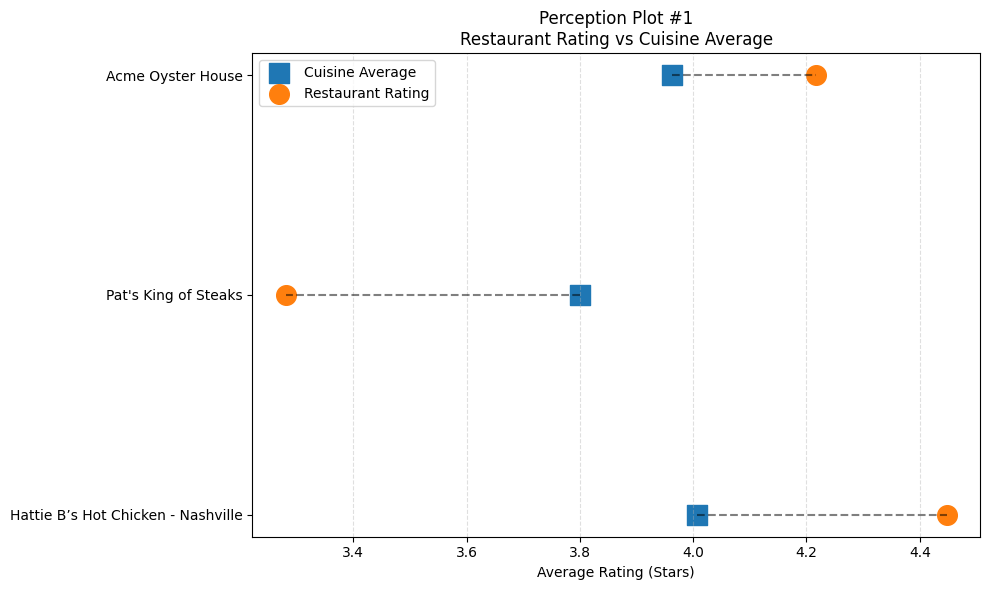

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute dominant cuisine per restaurant ---
cuisine_rows = restaurant_df[
    restaurant_df["human_label"].str.contains("Cuisine:", na=False)
]

dom_cuisine = (
    cuisine_rows
    .groupby(["business_id", "name", "human_label"])
    .size()
    .reset_index(name="count")
    .sort_values(["business_id", "count"], ascending=[True, False])
    .groupby("business_id")
    .head(1)
    .rename(columns={"human_label": "cuisine_label"})
    [["business_id", "name", "cuisine_label"]]
)

# --- Cuisine averages ---
cuisine_avg = (
    cuisine_rows
    .groupby("human_label")["review_stars"]
    .mean()
    .reset_index(name="cuisine_avg")
)

# --- Restaurant averages ---
restaurant_avg = (
    restaurant_df
    .groupby(["business_id", "name"])["review_stars"]
    .mean()
    .reset_index(name="restaurant_avg")
)

# --- Merge everything ---
rest_stats = (
    restaurant_avg
    .merge(dom_cuisine, on=["business_id", "name"], how="left")
    .merge(cuisine_avg, left_on="cuisine_label", right_on="human_label", how="left")
)

rest_top3 = rest_stats[rest_stats["business_id"].isin(top3_ids)]

# ---------------- PLOT -------------------
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(rest_top3))

plt.scatter(rest_top3["cuisine_avg"], y_pos, s=200, marker="s", label="Cuisine Average")
plt.scatter(rest_top3["restaurant_avg"], y_pos, s=200, label="Restaurant Rating")

# Connect with dashed lines
for i, row in rest_top3.iterrows():
    yp = np.where(rest_top3.index == i)[0][0]
    plt.plot([row["cuisine_avg"], row["restaurant_avg"]], [yp, yp], "k--", alpha=0.5)

plt.yticks(y_pos, rest_top3["name"])
plt.xlabel("Average Rating (Stars)")
plt.title("Perception Plot #1\nRestaurant Rating vs Cuisine Average")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


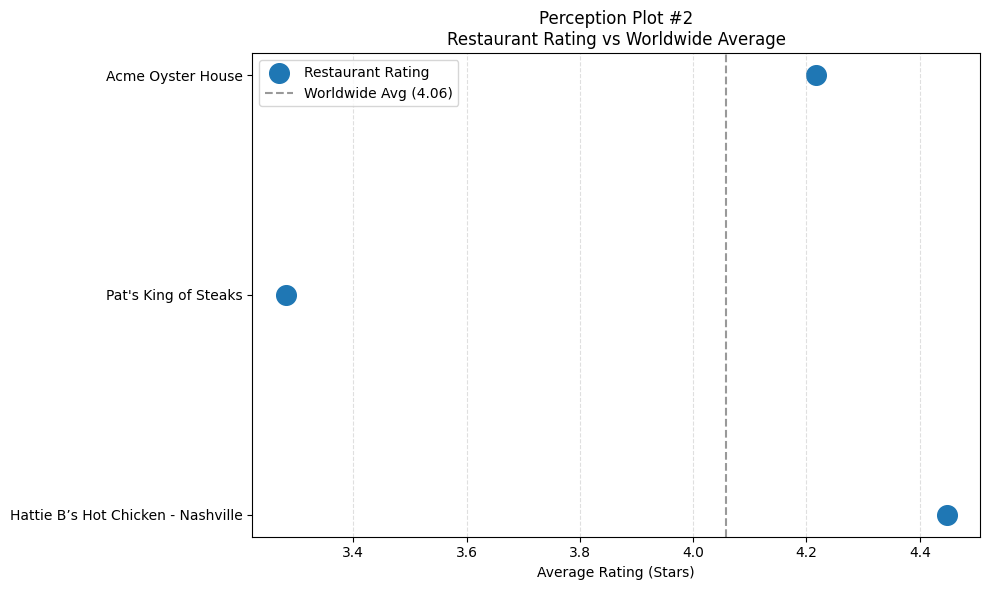

In [ ]:
# World average
world_avg = restaurant_df["review_stars"].mean()

plt.figure(figsize=(10, 6))

y_pos = np.arange(len(rest_top3))

# Restaurant averages again (already computed above)
plt.scatter(rest_top3["restaurant_avg"], y_pos, s=200, label="Restaurant Rating")

# World average vertical line
plt.axvline(x=world_avg, linestyle="--", color="gray",
            label=f"Worldwide Avg ({world_avg:.2f})", alpha=0.8)

plt.yticks(y_pos, rest_top3["name"])
plt.xlabel("Average Rating (Stars)")
plt.title("Perception Plot #2\nRestaurant Rating vs Worldwide Average")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


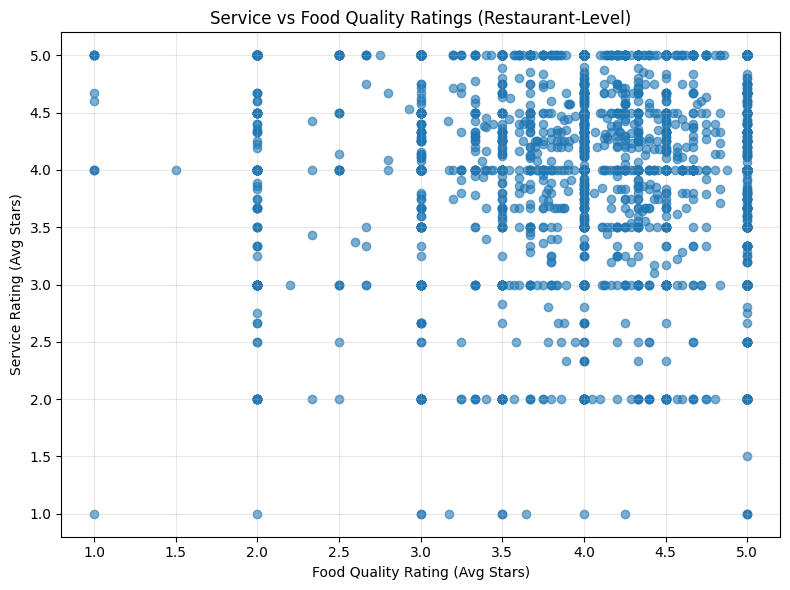

In [ ]:
# Filter only the aspect rows
aspect_df = restaurant_df[
    restaurant_df["human_label"].isin([
        "Aspect: Food Quality / Experience",
        "Aspect: Service / Staff"
    ])
]

# Compute avg rating per restaurant for each aspect
aspect_pivot = (
    aspect_df
    .groupby(["business_id", "name", "human_label"])["review_stars"]
    .mean()
    .reset_index()
    .pivot(index=["business_id", "name"],
           columns="human_label",
           values="review_stars")
    .dropna()
)

# Rename for cleaner column names
aspect_pivot = aspect_pivot.rename(columns={
    "Aspect: Food Quality / Experience": "Food_Quality",
    "Aspect: Service / Staff": "Service"
})

# -------- PLOT -------- #
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(aspect_pivot["Food_Quality"], aspect_pivot["Service"], alpha=0.6)

plt.xlabel("Food Quality Rating (Avg Stars)")
plt.ylabel("Service Rating (Avg Stars)")
plt.title("Service vs Food Quality Ratings (Restaurant-Level)")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


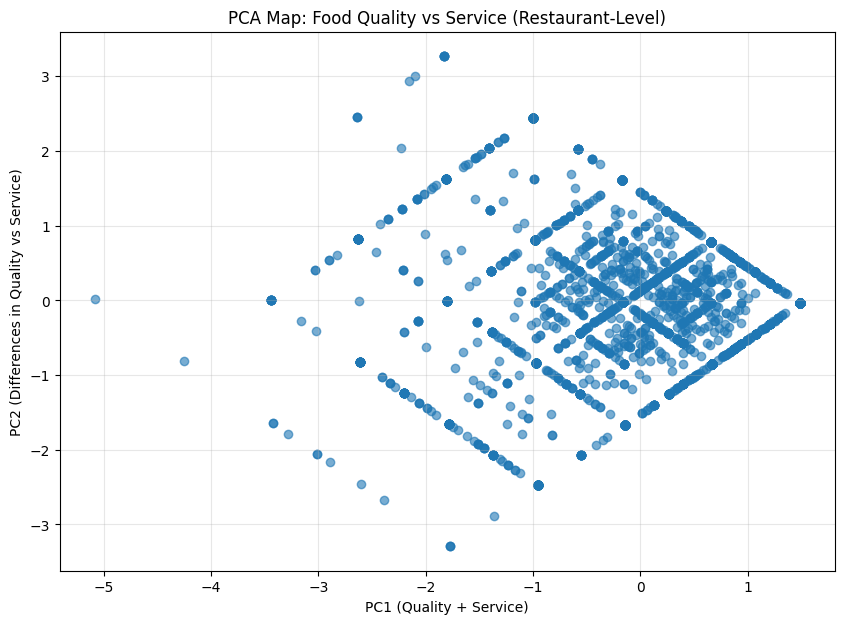

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Restaurant-level aggregated aspect scores
X = aspect_pivot[["Food_Quality", "Service"]]

scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(scaled)

pca_df = pd.DataFrame(components, columns=["PC1", "PC2"])
pca_df["name"] = aspect_pivot.index.get_level_values("name")

# ---- Plot ---- #
plt.figure(figsize=(10,7))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.6)

#for _, row in pca_df.iterrows():
 #   plt.annotate(row["name"], (row["PC1"], row["PC2"]), fontsize=7, alpha=0.7)

plt.xlabel("PC1 (Quality + Service)")
plt.ylabel("PC2 (Differences in Quality vs Service)")
plt.title("PCA Map: Food Quality vs Service (Restaurant-Level)")
plt.grid(alpha=0.3)
plt.show()
